In [2]:
import torch
# from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
class CTScanDataset(Dataset):
    def __init__(self, img_dir, length, mode, size, transform=None):
        self.mode = mode
        self.img_dir = img_dir
        self.transform = transform
       # self.target_transform = target_transform
        self.len = length
        self.size = size
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx): 
        slice_name = f"slice{idx:05d}"
        img_path = os.path.join(self.img_dir, slice_name, self.mode, 'reconstruction.tif')
        img = tiff.imread(img_path).astype(np.float32)
        img_tensor = torch.from_numpy(img)
        compressed_img = cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)
        compressed_img_tensor = torch.from_numpy(compressed_img)
        if self.transform:
            img_tensor = self.transform(img_tensor)
            compressed_img_tensor = self.transform(compressed_img_tensor)
        return img_tensor, compressed_img_tensor

In [4]:
img_dir = 'data/2DeteCT_slices1-1000_RecSeg'
mode = 'mode1'
length = 1000
size = (64, 64) # size of compressed images
dataset = CTScanDataset(img_dir, length, mode, size)

# grab samples from the dataset
flatten = True
num_samples = 600
X_full_raw = torch.stack([dataset[i][0] for i in range(1,num_samples)]) # X vector with uncompressed images
X_full = X_full_raw.view(num_samples-1, -1) if flatten else X_raw
X_np = X_full.cpu().numpy().T # Transpose to have each image as a column vector, features as rows (1024^2 x numSamples)

In [5]:
print(X_full.shape) # numSamples x 1024^2

r = 64 # reduce number of data points from 1024^2 to 512
X_np = X_full.cpu().numpy().T # Transpose to have each image as a column vector, features as rows (1024^2 x numSamples)
U, S, Vt = sp.sparse.linalg.svds(X_np, k=r)

# Ur, Sr, Vr = U[:, :r], S[:r], Vt[:r, :]
Xr = U @ np.diag(S) @ Vt # Reconstruct dataset

print(Xr.shape)

torch.Size([599, 1048576])
(1048576, 599)


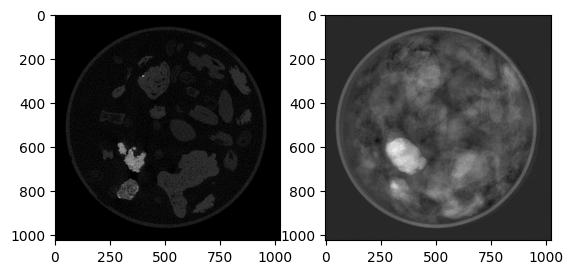

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_np[:,0].reshape(1024, 1024), cmap='gray')
ax[1].imshow(Xr[:,0].reshape(1024, 1024), cmap='gray')

Observation : SVD reduces rank, but does not reduce size (so it is not super useful here, since the second moment matrix would still end up being million x million in size). Also with very small ranks (like 32/64) the image is losing most of its clarity / is not useful anymore.

Need to find another method for size compression, while still preseving variance and also being able to reconstruct original sized image from compressed image afterwards.

In [7]:
# downsample and then upsample dataset images using cv2.resize and compare / compute loss

# X_np is of size (numSamples x 1024^2) -> full size data
# define new matrix X using the same dataset

X_compressed_raw = torch.stack([dataset[i][1] for i in range(1,num_samples)]) # X vector with compressed images
X_compressed = X_compressed_raw.view(num_samples-1, -1) if flatten else X_raw
X_compressed = X_compressed.cpu().numpy().T # Transpose to have each image as a column vector, features as rows (128 x 128 x numSamples)

X_reconstructed = np.zeros_like(X_np) # Initialize reconstructed images matrix
print(X_reconstructed.shape)

psnrs = np.zeros(num_samples)
ssims = np.zeros(num_samples)

# upsample compressed images using cv2.LANCZOS4
for i in range(X_reconstructed.shape[1]):
    original  = X_np[:, i].reshape(1024, 1024)  
    compressed =   X_compressed[:, i].reshape(size)
    reconstructed = cv2.resize(compressed, (1024, 1024), interpolation=cv2.INTER_LANCZOS4)
    X_reconstructed[:, i] = reconstructed.flatten()

    psnrs[i] = psnr(original, reconstructed, data_range=np.max(original) - np.min(original))
    ssims[i] = ssim(original, reconstructed, data_range=np.max(original) - np.min(original), full=False)


(1048576, 599)


KeyboardInterrupt: 

0.9574851
mean psnr27.934868627562416
mean ssim0.6024570831981217


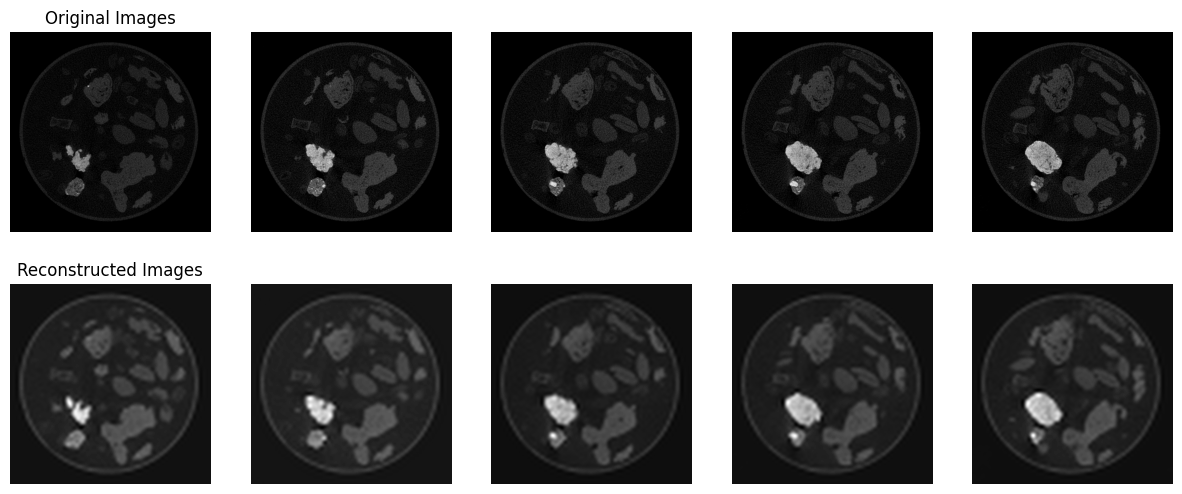

In [51]:
# calculate loss and visualize
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 6)
for i in range(2):
    ax[0, i].imshow(X_np[:, i].reshape(1024, 1024), cmap='gray')
    ax[0, 0].set_title('Original Images')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(X_reconstructed[:, i].reshape(1024, 1024), cmap='gray')
    ax[1, 0].set_title('Reconstructed Images')
    ax[1, i].axis('off')

difference = np.abs(X_np - X_reconstructed)
norm_difference = np.linalg.norm(difference, axis=0) / np.linalg.norm(X_np, axis=0) # norm of error for eacg image / norm of each image
mean_error = np.mean(norm_difference) # mean error across all images

print(mean_error)
print(f'mean psnr{np.mean(psnrs)}') # mean PSNR across all images
print(f'mean ssim{np.mean(ssims)}') # mean SSIM across all images

Simply Downsampling and Upsampling leads to a 33% error in the images, on average. However, this is just error calculated from norms and could related to noise-reduction, etc (it might be possible that the main features are still being preserved?)

Using cv2.inter_area and cv2.inter_lanczs0s4, 

with reduction to (64,64)
Mean PSNR (peak signal to noise ratio) value is 27 -> decent loss in compression, but acceptable
Mean SSIM (structural similarity measure) value is 0.6 -> poort quality
Normalized MSE is 0.38

with reduction to (128,128) (this is still not a feasible size because second moment matrix is 128^4)
Mean PSNR (peak signal to noise ratio) value is 29 -> decent loss in compression, but acceptable
Mean SSIM (structural similarity measure) value is 0.65 -> poort quality
Normalized MSE is 0.33

In [9]:
# try autoencoders with compressed images, then upsample them and compare all 5 (original, copmpressed, reconstructed, upsampled, difference)

# linear map, second moment estimation
gamma_X = X_compressed @ X_compressed.T
gamma_X += 1e-5*np.eye(gamma_X.shape[0]) # add the regularization term to ensure SPD
L_x = np.linalg.cholesky(gamma_X) # Cholesky decomposition

r = 512 # latent space dimension
U, Sigma, V_t = np.linalg.svd(L_x) # SVD
U_r = U[:, :r] # first r left singular vectors of L_X

reconstructed_X_covarianceMethod = U_r @ (U_r.T @ X_compressed)


In [53]:
psnrs = np.zeros(num_samples-1)
ssims = np.zeros(num_samples-1)

X_upsampled_covarianceMethod = np.zeros_like(X_np) # Initialize upsampled images matrix
for i in range(num_samples-1):
    original = X_np[:, i].reshape(1024, 1024)
    reconstructed = reconstructed_X_covarianceMethod[:, i].reshape(size)
    upsampled = cv2.resize(reconstructed, (1024, 1024), interpolation=cv2.INTER_LANCZOS4)
    X_upsampled_covarianceMethod[:, i] = upsampled.flatten()
    # Calculate PSNR and SSIM for each image
    psnrs[i] = psnr(original, upsampled, data_range=np.max(original) - np.min(original))
    ssims[i] = ssim(original, upsampled, data_range=np.max(original) - np.min(original), full=False)

# calculate normalized mean squared error between original and upsampled images, and compressed and reconstructed images
difference_originals = np.abs(X_np - X_upsampled_covarianceMethod)
norm_difference_originals = np.linalg.norm(difference_originals, axis=0) / np.linalg.norm(X_np, axis=0) # norm of error for eacg image / norm of each image
mean_error = np.mean(norm_difference_originals) # mean error across all images

difference_compressed = np.abs(X_compressed - reconstructed_X_covarianceMethod)
norm_difference_compressed = np.linalg.norm(difference_compressed, axis=0) / np.linalg.norm(X_compressed, axis=0) 
mean_error_compressed = np.mean(norm_difference_compressed) # mean error across all images

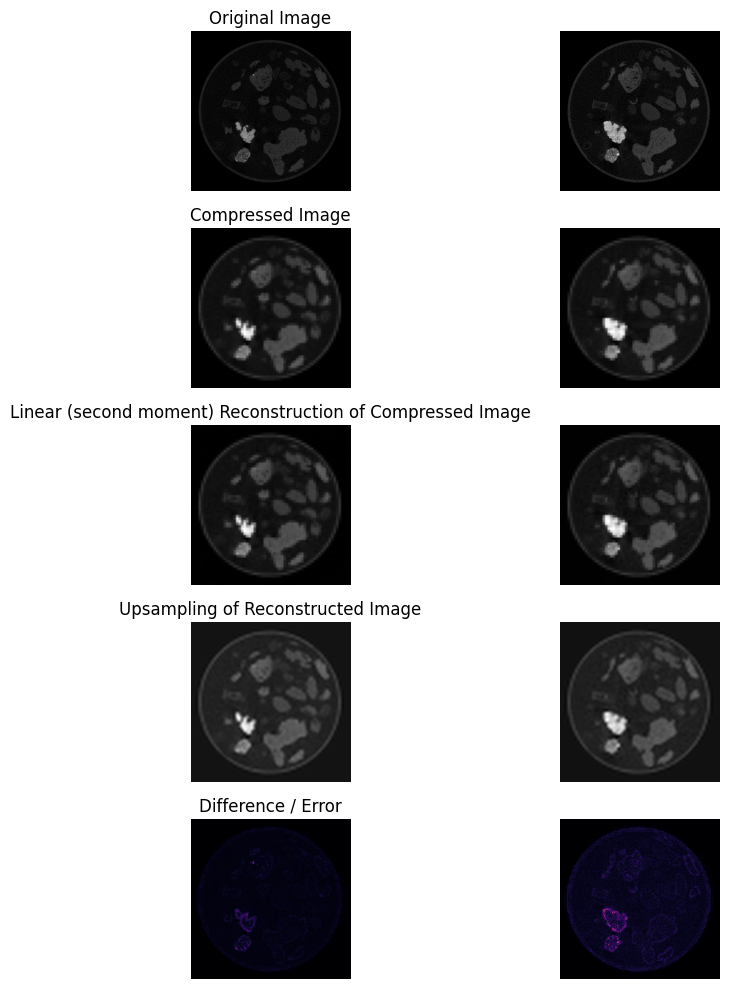

In [56]:
fig, ax = plt.subplots(5, 2, figsize=(15, 10))
fig.set_tight_layout(True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(2):
    original = X_np[:, i].reshape(1024, 1024)
    compressed = X_compressed[:, i].reshape(size)
    reconstructed = reconstructed_X_covarianceMethod[:, i].reshape(size)
    upsampled = X_upsampled_covarianceMethod[:, i].reshape(1024, 1024)

    ax[0,i].imshow(original, cmap='gray')
    ax[1,i].imshow(compressed, cmap='gray')
    ax[2,i].imshow(reconstructed, cmap='gray')
    ax[3,i].imshow(upsampled, cmap='gray')
    ax[4, i].imshow(np.abs(original - upsampled), cmap='inferno')

    ax[0,0].set_title(f'Original Image')
    ax[1,0].set_title(f'Compressed Image')
    ax[2,0].set_title(f'Linear (second moment) Reconstruction of Compressed Image')
    ax[3,0].set_title(f'Upsampling of Reconstructed Image')
    ax[4,0].set_title(f'Difference / Error')

    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[4, i].axis('off')


In [54]:
print(f'Mean PSNR (Covariance Method): {np.mean(psnrs)}')
print(f'Mean SSIM (Covariance Method): {np.mean(ssims)}')
print(f'Mean error (original vs upsampled): {mean_error}')
print(f'Mean error (compressed vs reconstructed): {mean_error_compressed}')

Mean PSNR (Covariance Method): 27.981504468342994
Mean SSIM (Covariance Method): 0.6034628546224926
Mean error (original vs upsampled): 0.3903437554836273
Mean error (compressed vs reconstructed): 0.030362652614712715


In [38]:
# Implement Afine Linear Autoencoder on compressed images
Sigma_X = np.cov(X_compressed) # covariance matrix of compressed images
mu_X = np.mean(X_compressed, axis=1)
Sigma_X += 1e-5 * np.eye(Sigma_X.shape[0]) # add a regularization term to ensure SPD
K_x = np.linalg.cholesky(Sigma_X)
U, D, V_t = np.linalg.svd(K_x)
U_r = U[:, :r]
A = U_r @ U_r.T
b = (np.eye(A.shape[0]) - A) @ mu_X
b = np.tile(b[:, np.newaxis], (1, num_samples-1))

In [52]:
reconstructed_X_afine = A @ X_compressed + b

psnrs = np.zeros(num_samples-1)
ssims = np.zeros(num_samples-1)
X_upsampled_afine = np.zeros_like(X_np) # Initialize upsampled images matrix
for i in range(num_samples-1):
    original = X_np[:, i].reshape(1024, 1024)
    reconstructed = reconstructed_X_afine[:, i].reshape(size)
    upsampled = cv2.resize(reconstructed, (1024, 1024), interpolation=cv2.INTER_LANCZOS4)
    X_upsampled_afine[:, i] = upsampled.flatten()
    # Calculate PSNR and SSIM for each image
    psnrs[i] = psnr(original, upsampled, data_range=np.max(original) - np.min(original))
    ssims[i] = ssim(original, upsampled, data_range=np.max(original) - np.min(original), full=False)

difference_originals_afine = np.abs(X_np - X_upsampled_afine)
norm_difference_originals = np.linalg.norm(difference_originals_afine, axis=0) / np.linalg.norm(X_np, axis=0) # norm of error for eacg image / norm of each image
mean_error_afine = np.mean(norm_difference_originals) # mean error across all images

difference_compressed_afine = np.abs(X_compressed - reconstructed_X_afine)
norm_difference_compressed = np.linalg.norm(difference_compressed_afine, axis=0) / np.linalg.norm(X_compressed, axis=0) 
mean_error_compressed_afine = np.mean(norm_difference_compressed) # mean error across all images

print(f'Mean error (original vs upsampled): {mean_error_afine}')
print(f'Mean error (compressed vs reconstructed): {mean_error_compressed_afine}')

print(f'Mean psnr (Affine Method): {np.mean(psnrs)}')
print(f'Mean ssim (Affine Method): {np.mean(ssims)}')

Mean error (original vs upsampled): 0.3903234302997589
Mean error (compressed vs reconstructed): 0.030109447236192927
Mean psnr (Affine Method): 27.981970979894825
Mean ssim (Affine Method): 0.6034785695392997


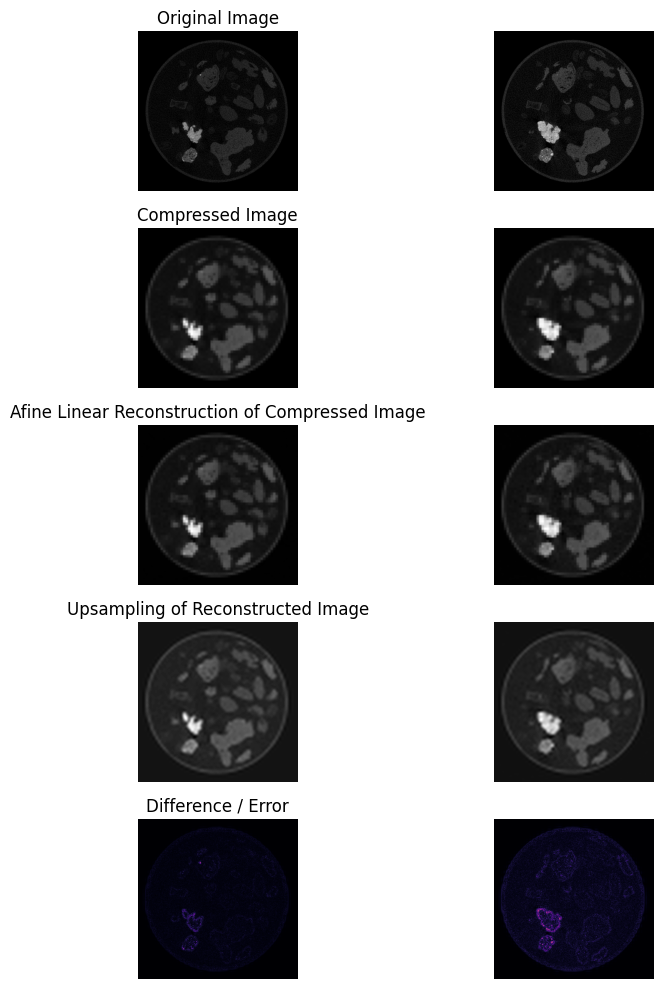

In [45]:
fig, ax = plt.subplots(5,2, figsize=(15, 10))
fig.set_tight_layout(True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(2):
    original = X_np[:, i].reshape(1024, 1024)
    compressed = X_compressed[:, i].reshape(size)
    reconstructed = reconstructed_X_afine[:, i].reshape(size)
    upsampled = X_upsampled_afine[:, i].reshape(1024, 1024)

    ax[0,i].imshow(original, cmap='gray')
    ax[1,i].imshow(compressed, cmap='gray')
    ax[2,i].imshow(reconstructed, cmap='gray')
    ax[3,i].imshow(upsampled, cmap='gray')
    ax[4, i].imshow(np.abs(original - upsampled), cmap='magma')

    ax[0,0].set_title(f'Original Image')
    ax[1,0].set_title(f'Compressed Image')
    ax[2,0].set_title(f'Afine Linear Reconstruction of Compressed Image')
    ax[3,0].set_title(f'Upsampling of Reconstructed Image')
    ax[4,0].set_title(f'Difference / Error')

    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[4, i].axis('off')

1.0


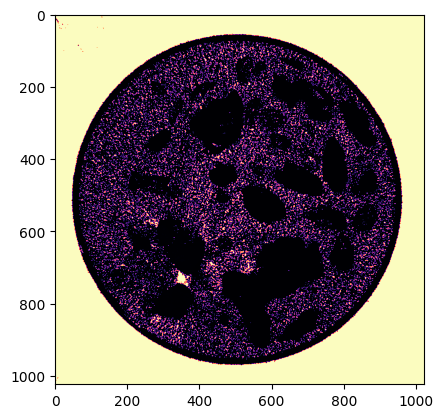

In [23]:
test_im = X_np[:,0]
idx = np.where(test_im == 0)

num_zeros= len(idx[0])

max_value = np.max(test_im)
print(max_value)

test_im[idx] = 1

plt.imshow(test_im.reshape(1024, 1024), cmap='magma')

nonzero_idx = np.nonzer(test_im)

plt.imshow(test_im.[reshape(1024, 1024)], cmap='magma')